In [1]:
import pandas as pd

# Load your CSV files (adjust filenames if needed)
date_df = pd.read_csv('dim_date.csv')
hotels_df = pd.read_csv('dim_hotels.csv')
rooms_df = pd.read_csv('dim_rooms.csv')
agg_bookings_df = pd.read_csv('fact_aggregated_bookings.csv')
bookings_df = pd.read_csv('fact_bookings.csv')

# Quick inspection of each dataframe
print("dim_date.csv:")
print(date_df.head(), '\n')

print("dim_hotels.csv:")
print(hotels_df.head(), '\n')

print("dim_rooms.csv:")
print(rooms_df.head(), '\n')

print("fact_aggregated_bookings.csv:")
print(agg_bookings_df.head(), '\n')

print("fact_bookings.csv:")
print(bookings_df.head(), '\n')


dim_date.csv:
        date  mmm yy week no  day_type
0  01-May-22  May 22    W 19   weekend
1  02-May-22  May 22    W 19  weekeday
2  03-May-22  May 22    W 19  weekeday
3  04-May-22  May 22    W 19  weekeday
4  05-May-22  May 22    W 19  weekeday 

dim_hotels.csv:
   property_id  property_name  category    city
0        16558   Atliq Grands    Luxury   Delhi
1        16559  Atliq Exotica    Luxury  Mumbai
2        16560     Atliq City  Business   Delhi
3        16561      Atliq Blu    Luxury   Delhi
4        16562      Atliq Bay    Luxury   Delhi 

dim_rooms.csv:
  room_id    room_class
0     RT1      Standard
1     RT2         Elite
2     RT3       Premium
3     RT4  Presidential 

fact_aggregated_bookings.csv:
   property_id check_in_date room_category  successful_bookings  capacity
0        16559     01-May-22           RT1                   25        30
1        19562     01-May-22           RT1                   28        30
2        19563     01-May-22           RT1             

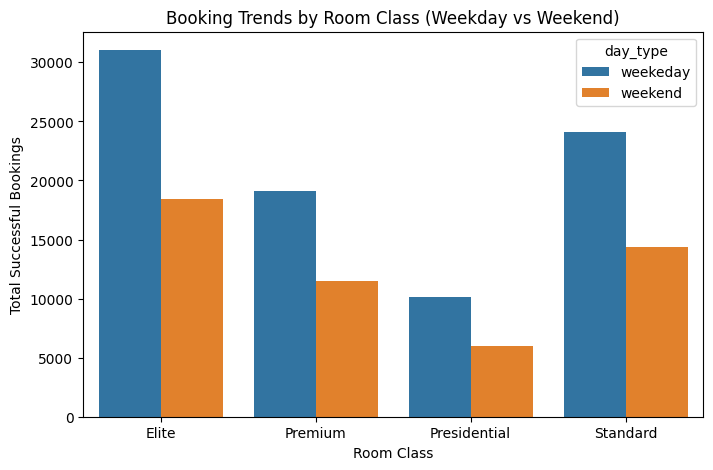

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSVs (if not already loaded)
date_df = pd.read_csv('dim_date.csv')
hotels_df = pd.read_csv('dim_hotels.csv')
rooms_df = pd.read_csv('dim_rooms.csv')
agg_bookings_df = pd.read_csv('fact_aggregated_bookings.csv')

# Merge for analysis
merged_df = pd.merge(
    agg_bookings_df,
    date_df,
    left_on='check_in_date',
    right_on='date',
    how='left'
)
merged_df = pd.merge(
    merged_df,
    hotels_df,
    on='property_id',
    how='left'
)
merged_df = pd.merge(
    merged_df,
    rooms_df,
    left_on='room_category',
    right_on='room_id',
    how='left'
)

# Booking trends: weekday vs weekend, by room class
trend_df = merged_df.groupby(['day_type', 'room_class'])['successful_bookings'].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=trend_df, x='room_class', y='successful_bookings', hue='day_type')
plt.title('Booking Trends by Room Class (Weekday vs Weekend)')
plt.xlabel('Room Class')
plt.ylabel('Total Successful Bookings')
plt.show()


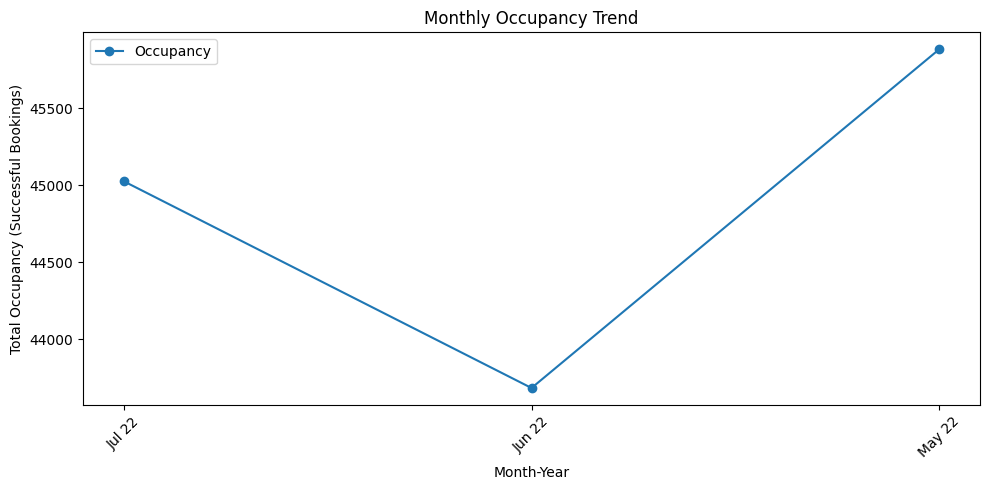

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Ensure merged_df from previous part is available
# If not, re-run the merge code from Part 2

# If your merged_df doesn't have a 'revenue_realized' column, use 'successful_bookings' as a proxy for occupancy.
# If you have actual revenue in another table, merge it as needed.

# Group by month-year for seasonal analysis
seasonal_df = merged_df.groupby('mmm yy').agg(
    occupancy=('successful_bookings', 'sum'),
    # Use revenue_realized if available; otherwise, skip or use another revenue column
    # revenue=('revenue_realized', 'sum')
).reset_index()

# If you have a revenue column, uncomment and use it above

# Plot occupancy trend by month
plt.figure(figsize=(10,5))
plt.plot(seasonal_df['mmm yy'], seasonal_df['occupancy'], marker='o', label='Occupancy')
plt.title('Monthly Occupancy Trend')
plt.xlabel('Month-Year')
plt.ylabel('Total Occupancy (Successful Bookings)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# If you have revenue data, plot and compute correlation
# Uncomment and adjust as needed
# plt.figure(figsize=(10,5))
# plt.plot(seasonal_df['month-year'], seasonal_df['revenue'], marker='s', color='orange', label='Revenue')
# plt.title('Monthly Revenue Trend')
# plt.xlabel('Month-Year')
# plt.ylabel('Total Revenue')
# plt.xticks(rotation=45)
# plt.legend()
# plt.tight_layout()
# plt.show()

# If both occupancy and revenue are available, calculate correlation
# corr, p_value = pearsonr(seasonal_df['occupancy'], seasonal_df['revenue'])
# print(f"Correlation between Occupancy and Revenue: {corr:.2f} (p-value: {p_value:.4f})")

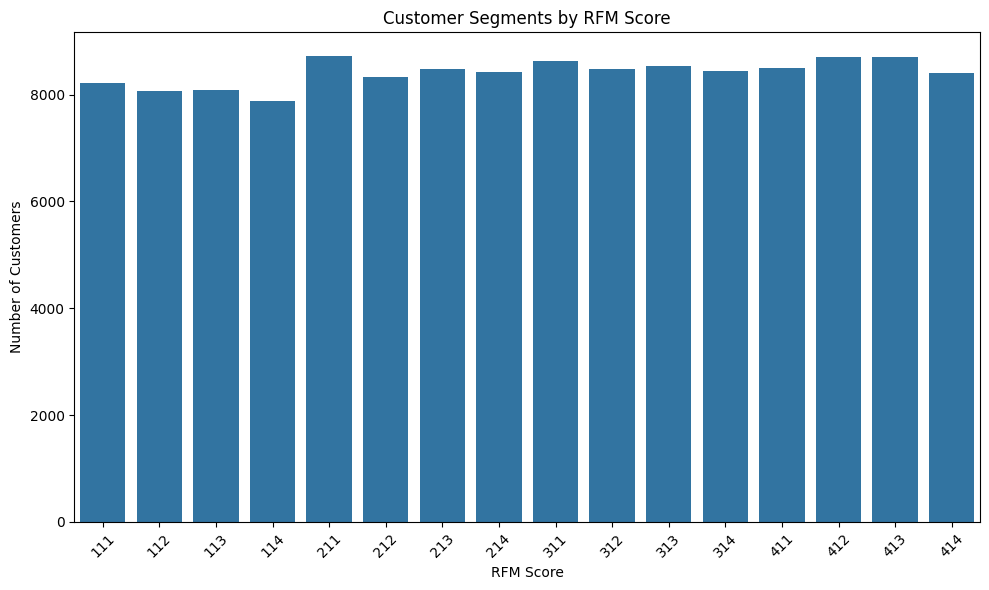

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# Load bookings_df
bookings_df = pd.read_csv('fact_bookings.csv')

# Convert dates to datetime
bookings_df['booking_date'] = pd.to_datetime(bookings_df['booking_date'])
bookings_df['check_in_date'] = pd.to_datetime(bookings_df['check_in_date'])
bookings_df['checkout_date'] = pd.to_datetime(bookings_df['checkout_date'])

# Calculate recency relative to latest booking
latest_booking_date = bookings_df['booking_date'].max()

# Create RFM dataframe
rfm_df = bookings_df.groupby('booking_id').agg(
    recency=('booking_date', lambda x: (latest_booking_date - x.max()).days),
    frequency=('booking_id', 'count'),
    monetary=('revenue_realized', 'sum')
).reset_index()

# Calculate recency quartiles (reverse order: smaller recency = better)
rfm_df['R_quartile'] = pd.qcut(rfm_df['recency'], 4, labels=[4, 3, 2, 1])

# Handle frequency quartiles with duplicate values
try:
    rfm_df['F_quartile'] = pd.qcut(rfm_df['frequency'], 4, labels=[1, 2, 3, 4], duplicates='drop')
except ValueError:
    # If all frequencies are identical (1 booking per ID)
    rfm_df['F_quartile'] = 1  # Assign lowest tier

# Handle monetary quartiles
try:
    rfm_df['M_quartile'] = pd.qcut(rfm_df['monetary'], 4, labels=[1, 2, 3, 4], duplicates='drop')
except ValueError:
    # Fallback if monetary values can't be quartiled
    rfm_df['M_quartile'] = pd.qcut(rfm_df['monetary'],
                                   q=min(4, len(rfm_df['monetary'].unique())),
                                   labels=False) + 1

# Create RFM score
rfm_df['RFM_Score'] = (
    rfm_df['R_quartile'].astype(str) +
    rfm_df['F_quartile'].astype(str) +
    rfm_df['M_quartile'].astype(str)
)

# Visualize results
plt.figure(figsize=(10, 6))
sns.countplot(
    data=rfm_df,
    x='RFM_Score',
    order=sorted(rfm_df['RFM_Score'].unique())
)
plt.title('Customer Segments by RFM Score')
plt.xlabel('RFM Score')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


   booking_status room_category  count  lost_revenue
0       Cancelled           RT1   9530      89940500
1       Cancelled           RT2  12357     164458260
2       Cancelled           RT3   7605     135719160
3       Cancelled           RT4   3928     107840390
4     Checked Out           RT1  26967     255075405
5     Checked Out           RT2  34653     461430180
6     Checked Out           RT3  21447     381040680
7     Checked Out           RT4  11344     311567700
8         No Show           RT1   1949      18529290
9         No Show           RT2   2495      33057720
10        No Show           RT3   1514      26838000
11        No Show           RT4    801      22048930


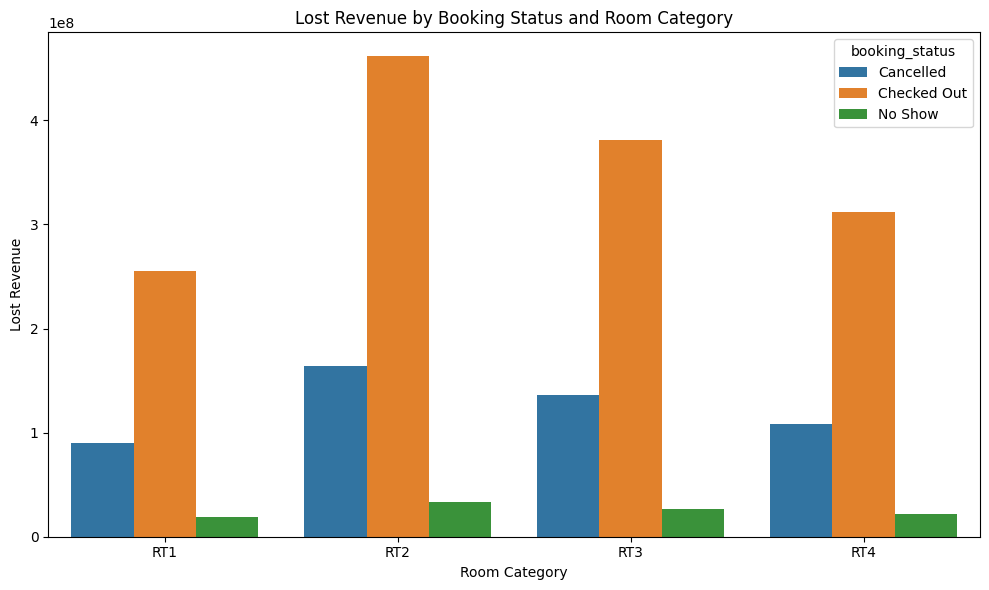

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We'll use bookings_df from previous steps

# Group by booking_status and room_category to analyze impact
cancelled_df = bookings_df.groupby(['booking_status', 'room_category']).agg(
    count=('booking_id', 'count'),
    lost_revenue=('revenue_generated', 'sum')
).reset_index()

print(cancelled_df)

# Visualize lost revenue by status and room category
plt.figure(figsize=(10,6))
sns.barplot(
    data=cancelled_df,
    x='room_category',
    y='lost_revenue',
    hue='booking_status'
)
plt.title('Lost Revenue by Booking Status and Room Category')
plt.xlabel('Room Category')
plt.ylabel('Lost Revenue')
plt.tight_layout()
plt.show()

  booking_platform  total_bookings  total_revenue  avg_rating
0   direct offline            6755       86404333    3.621784
1    direct online           13379      169026467    3.612289
2          journey            8106      102531334    3.626659
3          logtrip           14756      187554488    3.624620
4     makeyourtrip           26898      340834504    3.615507
5           others           55066      699353302    3.619019
6         tripster            9630      123066801    3.620817


/tmp/ipython-input-14-3393202342.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


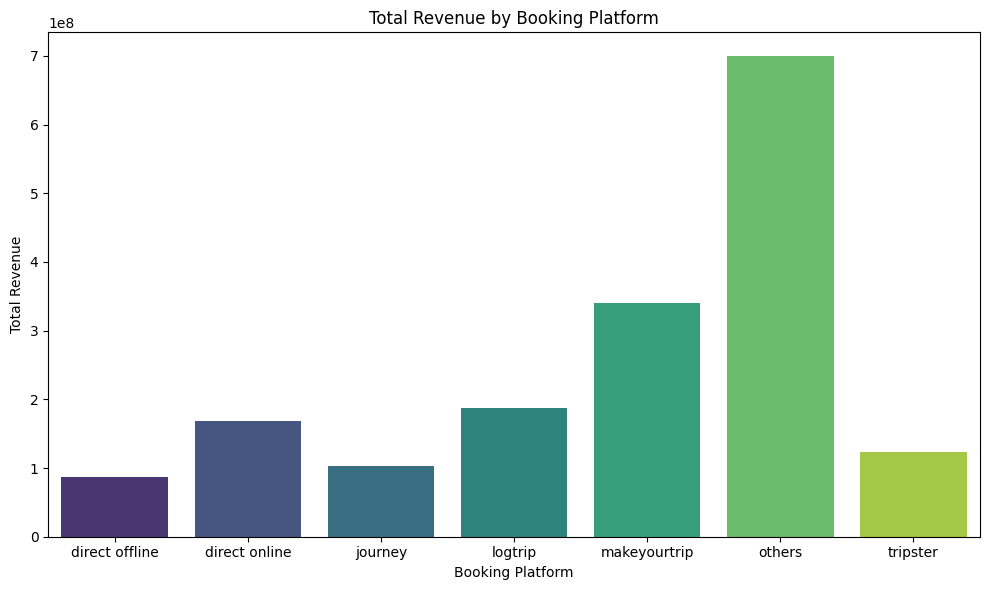

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# bookings_df is already loaded

# Group by booking platform
channel_df = bookings_df.groupby('booking_platform').agg(
    total_bookings=('booking_id', 'count'),
    total_revenue=('revenue_realized', 'sum'),
    avg_rating=('ratings_given', 'mean')
).reset_index()

print(channel_df)

# Visualize total revenue by booking platform
plt.figure(figsize=(10,6))
sns.barplot(
    data=channel_df,
    x='booking_platform',
    y='total_revenue',
    palette='viridis'
)
plt.title('Total Revenue by Booking Platform')
plt.xlabel('Booking Platform')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.show()


   length_of_stay  num_bookings  total_revenue
0               1         64066      813540672
1               2         27144      346926362
2               3         10842      137885543
3               4          6717       84777859
4               5         13083      164850438
5               6         12738      160790355


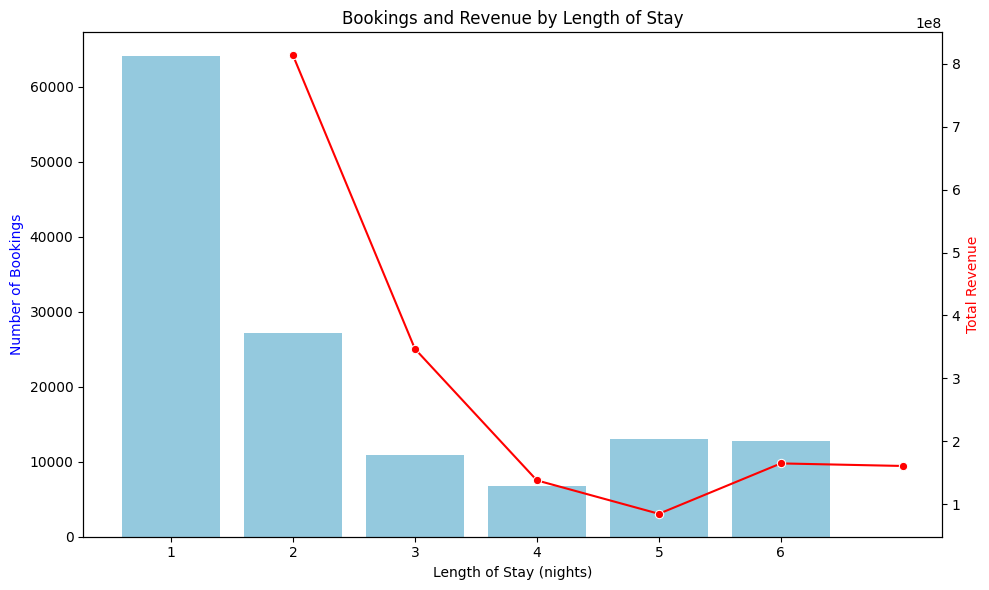

   lead_time  num_bookings  total_revenue
0          0         23447      302369664
1          1         19591      249076212
2          2         22701      287369568
3          3         20786      264032359
4          4         16117      202992302


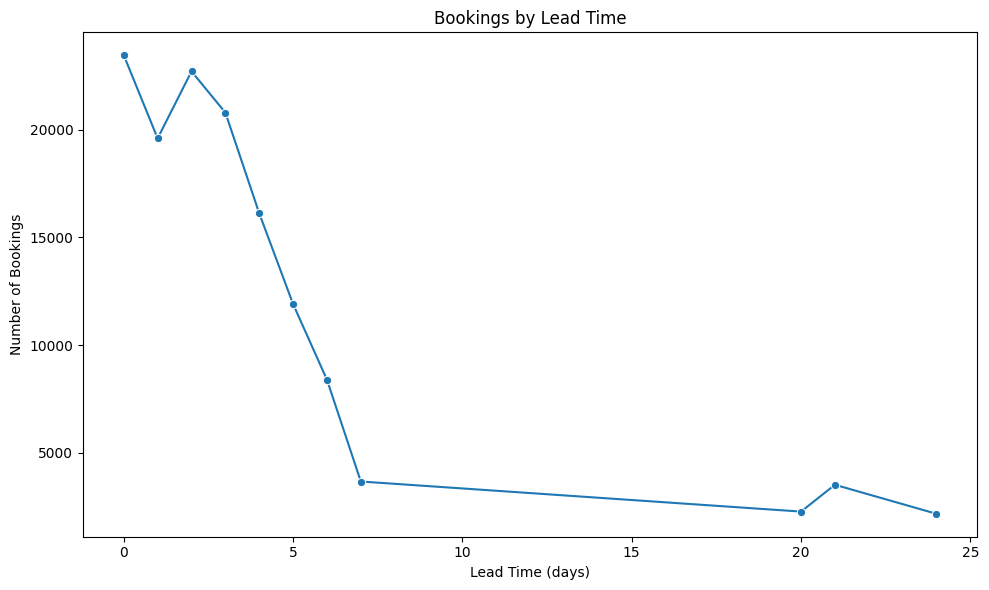

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# bookings_df is already loaded and date columns are in datetime format

# Calculate length of stay (nights)
bookings_df['length_of_stay'] = (bookings_df['checkout_date'] - bookings_df['check_in_date']).dt.days

# Calculate lead time (days between booking and check-in)
bookings_df['lead_time'] = (bookings_df['check_in_date'] - bookings_df['booking_date']).dt.days

# Group by length of stay
stay_df = bookings_df.groupby('length_of_stay').agg(
    num_bookings=('booking_id', 'count'),
    total_revenue=('revenue_realized', 'sum')
).reset_index()

print(stay_df)

# Visualize bookings and revenue by length of stay
fig, ax1 = plt.subplots(figsize=(10,6))

sns.barplot(
    data=stay_df,
    x='length_of_stay',
    y='num_bookings',
    color='skyblue',
    ax=ax1
)
ax1.set_ylabel('Number of Bookings', color='blue')
ax1.set_xlabel('Length of Stay (nights)')
ax1.set_title('Bookings and Revenue by Length of Stay')

# Plot revenue on secondary axis
ax2 = ax1.twinx()
sns.lineplot(
    data=stay_df,
    x='length_of_stay',
    y='total_revenue',
    color='red',
    marker='o',
    ax=ax2
)
ax2.set_ylabel('Total Revenue', color='red')

plt.tight_layout()
plt.show()

# (Optional) Lead time analysis
lead_df = bookings_df.groupby('lead_time').agg(
    num_bookings=('booking_id', 'count'),
    total_revenue=('revenue_realized', 'sum')
).reset_index()

print(lead_df.head())

plt.figure(figsize=(10,6))
sns.lineplot(
    data=lead_df,
    x='lead_time',
    y='num_bookings',
    marker='o'
)
plt.title('Bookings by Lead Time')
plt.xlabel('Lead Time (days)')
plt.ylabel('Number of Bookings')
plt.tight_layout()
plt.show()


     room_class  total_bookings  total_capacity  utilization_rate
0         Elite           49505           85928          0.576122
1       Premium           30566           53084          0.575804
2  Presidential           16073           27140          0.592225
3      Standard           38446           66424          0.578797


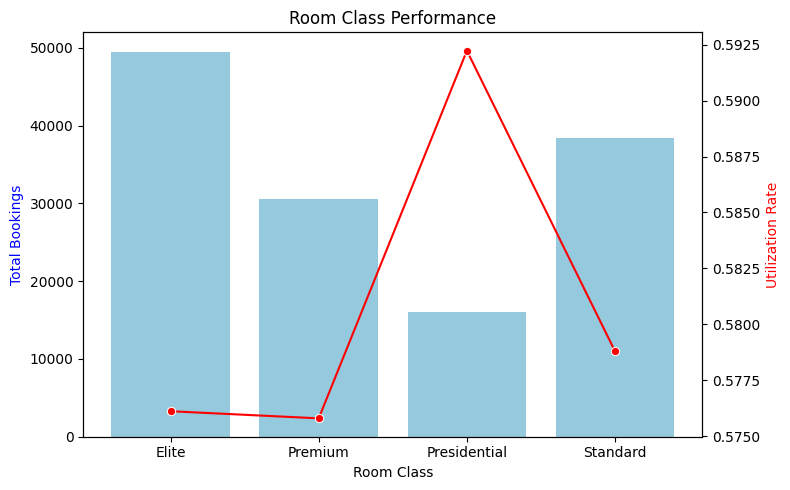

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# If not already merged, merge agg_bookings_df with rooms_df to get room_class
room_perf_df = pd.merge(
    agg_bookings_df,
    rooms_df,
    left_on='room_category',
    right_on='room_id',
    how='left'
)

# If you have 'revenue_realized' in agg_bookings_df, use it. Otherwise, use successful_bookings as a proxy for performance.
# Here, we'll use successful_bookings and capacity for utilization.

room_summary = room_perf_df.groupby('room_class').agg(
    total_bookings=('successful_bookings', 'sum'),
    total_capacity=('capacity', 'sum')
).reset_index()

room_summary['utilization_rate'] = room_summary['total_bookings'] / room_summary['total_capacity']

print(room_summary)

# Visualize occupancy and utilization by room class
fig, ax1 = plt.subplots(figsize=(8,5))
sns.barplot(data=room_summary, x='room_class', y='total_bookings', color='skyblue', ax=ax1)
ax1.set_ylabel('Total Bookings', color='blue')
ax1.set_xlabel('Room Class')
ax1.set_title('Room Class Performance')

# Plot utilization rate on secondary axis
ax2 = ax1.twinx()
sns.lineplot(data=room_summary, x='room_class', y='utilization_rate', color='red', marker='o', ax=ax2)
ax2.set_ylabel('Utilization Rate', color='red')

plt.tight_layout()
plt.show()


Estimated Total Revenue Leakage: ₹1,244,042,333

Top 5 Properties by Revenue Leakage:
    property_id  leaked_revenue
14        18559    8.277872e+07
19        19558    6.948588e+07
8         17560    6.732754e+07
22        19561    6.383611e+07
12        17564    6.274424e+07


/tmp/ipython-input-17-645159464.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


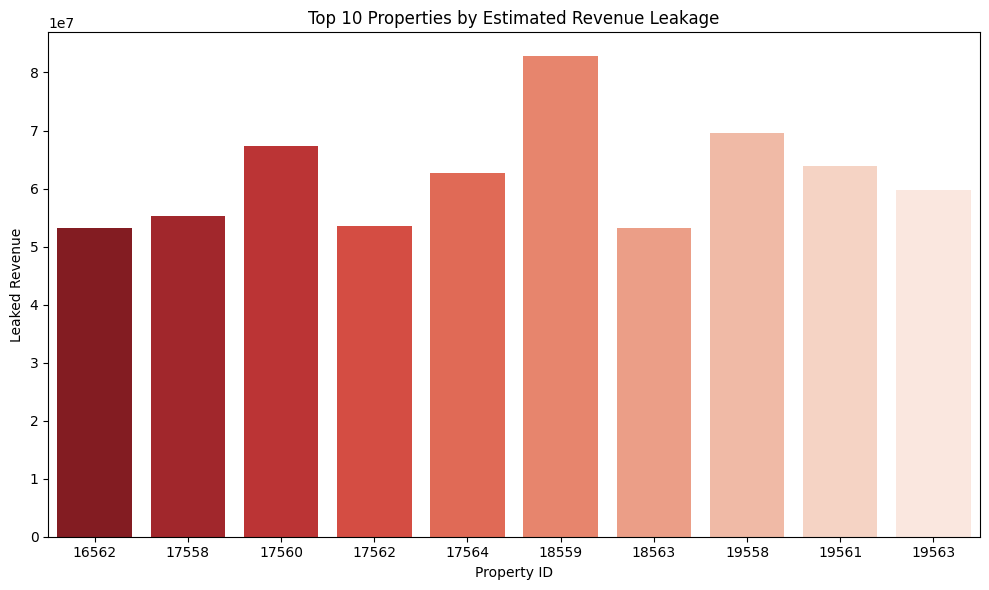

In [17]:
import pandas as pd

# If you have ADR, use it; else, estimate ADR from bookings
if 'ADR' in agg_bookings_df.columns:
    adr_value = agg_bookings_df['ADR']
else:
    # Estimate ADR from bookings_df (total realized revenue / total successful bookings)
    total_revenue = bookings_df['revenue_realized'].sum()
    total_bookings = bookings_df['booking_id'].count()
    estimated_adr = total_revenue / total_bookings if total_bookings > 0 else 0

# Calculate unsold capacity and revenue leakage per property and date
leakage_df = agg_bookings_df.copy()
leakage_df['unsold_rooms'] = leakage_df['capacity'] - leakage_df['successful_bookings']
leakage_df['unsold_rooms'] = leakage_df['unsold_rooms'].clip(lower=0)  # No negative rooms

# Use estimated ADR for leakage calculation
leakage_df['leaked_revenue'] = leakage_df['unsold_rooms'] * estimated_adr

# Aggregate total leakage per property or overall
total_leakage = leakage_df['leaked_revenue'].sum()
print(f"Estimated Total Revenue Leakage: ₹{total_leakage:,.0f}")

# Top properties with highest leakage
leakage_by_property = leakage_df.groupby('property_id')['leaked_revenue'].sum().reset_index()
leakage_by_property = leakage_by_property.sort_values('leaked_revenue', ascending=False)

print("\nTop 5 Properties by Revenue Leakage:")
print(leakage_by_property.head())

# Visualize leakage by property (Top 10)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
sns.barplot(
    data=leakage_by_property.head(10),
    x='property_id',
    y='leaked_revenue',
    palette='Reds_r'
)
plt.title('Top 10 Properties by Estimated Revenue Leakage')
plt.xlabel('Property ID')
plt.ylabel('Leaked Revenue')
plt.tight_layout()
plt.show()



Data types before bookings_merge: property_id               int64
check_in_date    datetime64[ns]
room_category            object
dtype: object property_id               int64
check_in_date    datetime64[ns]
room_category            object
dtype: object

Shape of bookings_df before merge: (134590, 12)

Shape of agg_rooms before merge: (9200, 7)

Shape of bookings_merge after merge: (134590, 14)

Head of bookings_merge after merge:
          booking_id  property_id booking_date check_in_date checkout_date  \
0  May012216558RT11        16558   2022-04-27    2022-05-01    2022-05-02   
1  May012216558RT12        16558   2022-04-30    2022-05-01    2022-05-02   
2  May012216558RT13        16558   2022-04-28    2022-05-01    2022-05-04   
3  May012216558RT14        16558   2022-04-28    2022-05-01    2022-05-02   
4  May012216558RT15        16558   2022-04-27    2022-05-01    2022-05-02   

   no_guests room_category booking_platform  ratings_given booking_status  \
0          3           

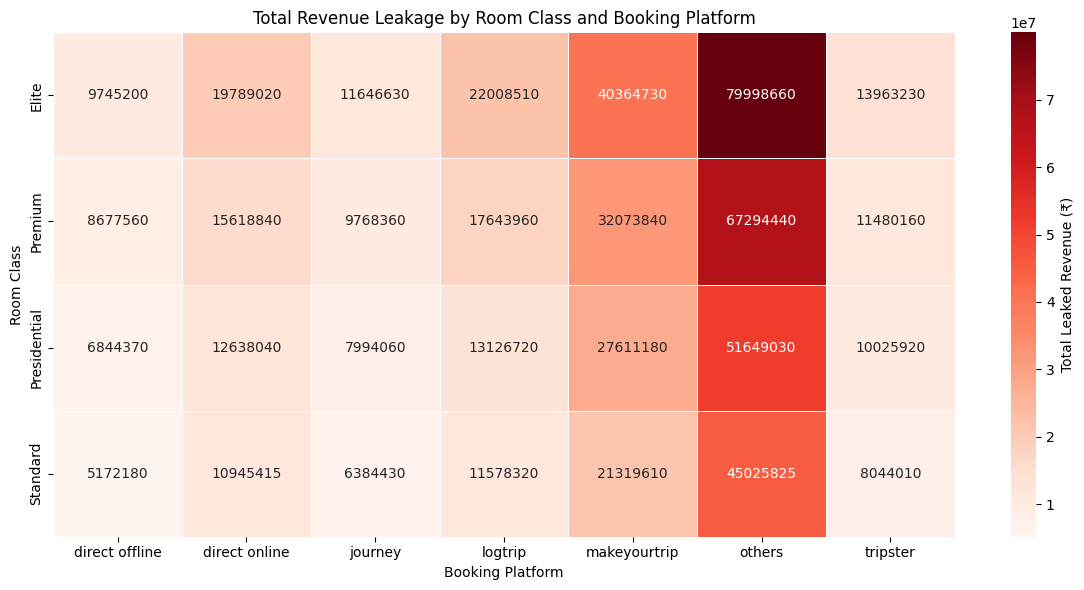

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load CSVs (assumes files are present in the Colab environment)
date_df = pd.read_csv('dim_date.csv')
hotels_df = pd.read_csv('dim_hotels.csv')
rooms_df = pd.read_csv('dim_rooms.csv')
agg_bookings_df = pd.read_csv('fact_aggregated_bookings.csv')
bookings_df = pd.read_csv('fact_bookings.csv')

# Convert date columns to datetime, specifying format for clarity
bookings_df['booking_date'] = pd.to_datetime(bookings_df['booking_date'])
bookings_df['check_in_date'] = pd.to_datetime(bookings_df['check_in_date'])
bookings_df['checkout_date'] = pd.to_datetime(bookings_df['checkout_date'])
date_df['date'] = pd.to_datetime(date_df['date'], format='%d-%b-%y') # Specify format based on data inspection
agg_bookings_df['check_in_date'] = pd.to_datetime(agg_bookings_df['check_in_date'], format='%d-%b-%y') # Convert for merging


# --- Revenue Leakage Calculation ---
total_revenue = bookings_df['revenue_realized'].sum()
total_bookings = bookings_df['booking_id'].count()
estimated_adr = total_revenue / total_bookings if total_bookings > 0 else 0


# --- Revenue Leakage Heatmap by Room Class and Booking Platform ---

# Ensure check_in_date is datetime in agg_bookings_df before merging
agg_bookings_df['check_in_date'] = pd.to_datetime(agg_bookings_df['check_in_date'], format='%d-%b-%y')

# Merge agg_bookings with room info
agg_rooms = pd.merge(agg_bookings_df, rooms_df, left_on='room_category', right_on='room_id', how='left')

# Merge bookings with agg_bookings to get booking_platform for each record
# For each booking, find the corresponding agg row (by property_id, check_in_date, room_category)
print("\nData types before bookings_merge:", bookings_df[['property_id', 'check_in_date', 'room_category']].dtypes, agg_rooms[['property_id', 'check_in_date', 'room_category']].dtypes)
print("\nShape of bookings_df before merge:", bookings_df.shape)
print("\nShape of agg_rooms before merge:", agg_rooms.shape)

bookings_merge = pd.merge(
    bookings_df,
    agg_rooms[['property_id', 'check_in_date', 'room_category', 'room_class', 'capacity']],
    on=['property_id', 'check_in_date', 'room_category'],
    how='left'
)

print("\nShape of bookings_merge after merge:", bookings_merge.shape)
print("\nHead of bookings_merge after merge:\n", bookings_merge.head())

# Calculate unsold rooms per booking record (capacity - 1 if booking is successful, else capacity)
# Note: This calculation of 'unsold' per *booking record* is not standard for leakage.
# Leakage is typically calculated at the aggregated level (capacity - successful bookings).
# Reverting to the aggregated level calculation for heatmap.

# Calculate unsold rooms and leaked revenue at the aggregated level
leakage_agg = agg_bookings_df.copy()
leakage_agg['unsold_rooms'] = leakage_agg['capacity'] - leakage_agg['successful_bookings']
leakage_agg['unsold_rooms'] = leakage_agg['unsold_rooms'].clip(lower=0)
leakage_agg['leaked_revenue'] = leakage_agg['unsold_rooms'] * estimated_adr # Using estimated ADR

# Merge aggregated leakage with room info and booking platform (requires merging with bookings_df to get platform)
# This merge logic needs rethinking as aggregated data (agg_bookings_df) doesn't have booking platform directly.
# We need to calculate leakage *per platform* from the bookings_df.

# Recalculating leakage per platform and room class from bookings_df
# For simplicity and to align with the heatmap structure, let's calculate leaked revenue per booking
# and then aggregate by room class and booking platform.
# Leaked revenue per booking: revenue_generated for Cancelled/No Show bookings.

bookings_df['leaked_revenue_per_booking'] = bookings_df.apply(
    lambda row: row['revenue_generated'] if row['booking_status'] in ['Cancelled', 'No Show'] else 0,
    axis=1
)

# Merge bookings_df with rooms_df to get room_class
bookings_with_room_class = pd.merge(bookings_df, rooms_df, left_on='room_category', right_on='room_id', how='left')

# Group by room_class and booking_platform to get total leaked revenue
leakage_platform_heatmap_data = bookings_with_room_class.groupby(['room_class', 'booking_platform']).agg(
    total_leaked_revenue=('leaked_revenue_per_booking', 'sum')
).reset_index()

# Pivot for heatmap
heatmap_df = leakage_platform_heatmap_data.pivot(index='room_class', columns='booking_platform', values='total_leaked_revenue').fillna(0)

print("\nHead of heatmap_df before plotting:\n", heatmap_df.head())


# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_df, annot=True, fmt=".0f", cmap='Reds', linewidths=.5, cbar_kws={'label': 'Total Leaked Revenue (₹)'}
)
plt.title('Total Revenue Leakage by Room Class and Booking Platform')
plt.ylabel('Room Class')
plt.xlabel('Booking Platform')
plt.tight_layout()
plt.show()